In [1]:
import sys
import yaml
import pyart
import json
import joblib
import numpy as np
import pandas as pd
from analysis import *
import scipy.stats as ss
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('../scripts')
import core


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



# NAT8A ALPHA

In [2]:
exp='nat8a'
dataset = 'alpha'
stim_info = pd.read_csv(f"../inputs/stimuli/{exp}-info.csv")
spectrograms = pd.read_csv(f"../build/{exp}/spectrograms.csv", index_col=[0,1])
motifs = stim_info.motif.unique()
gap_times = stim_info[stim_info.type=='gap'].groupby(['motif','gap']).first()[['gap_start', 'gap_stop']]

In [3]:
# Ends of each CI from motif end:
cstims = [f"{m}_continuous" for m in motifs]
ends = spectrograms.groupby('stimulus')\
.apply(lambda df: df.index.get_level_values(1).max())\
.loc[cstims].sort_index()
stops = gap_times.groupby('motif').apply(lambda x: x.gap_stop.max()).sort_index()
ends.values-stops.values

array([281., 263., 435., 349., 269., 274., 293., 324.])

## Average CI response rate

In [6]:
units = []
for room in ['178B', '180B']:
    with open(f'../inputs/units/{exp}-{dataset}-{room}.txt') as ufile:
        units.extend(ufile.read().split('\n'))

data = []
for u in units:
    pprox_file = Path(f"../datasets/{exp}-{dataset}-responses/{u}.pprox")
    pprox_data = json.loads(pprox_file.read_text())
    unit_data = pd.json_normalize(pprox_data["pprox"]).rename(
        columns = {'stimulus': 'motif'}
    )
    unit_data['stimulus'] = unit_data["motif"] + "_" + unit_data["condition"]
    unit_data.set_index('stimulus', inplace=True)
    for (m, g), gapdata in gap_times.iterrows():
        ga, gb = gapdata
        for c in ['C','GB','N', 'G', 'CB']:
            stim = aname(m, c, g)
            mean = unit_data.loc[stim].event.apply(
                lambda events: len([i for i in events if ga<=i<=gb+50])
            ).mean() / (gb-ga)
            data.append({'unit': u, 'motif':m, 'gap': g, 'condition':c, 'mean': mean})
data = pd.DataFrame(data)
data.head()

,unit,motif,gap,condition,mean
0,O129_p2r3_ch4_c33,B189,1.0,C,0.019792
1,O129_p2r3_ch4_c33,B189,1.0,GB,0.000000
2,O129_p2r3_ch4_c33,B189,1.0,N,0.002083
3,O129_p2r3_ch4_c33,B189,1.0,G,0.000000
4,O129_p2r3_ch4_c33,B189,1.0,CB,0.001042


## Firing rate of pairwise conditions

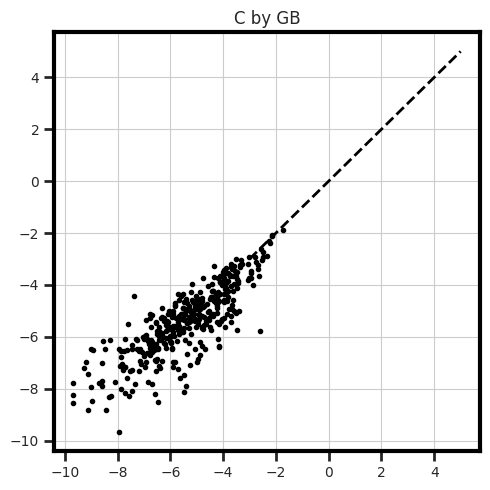

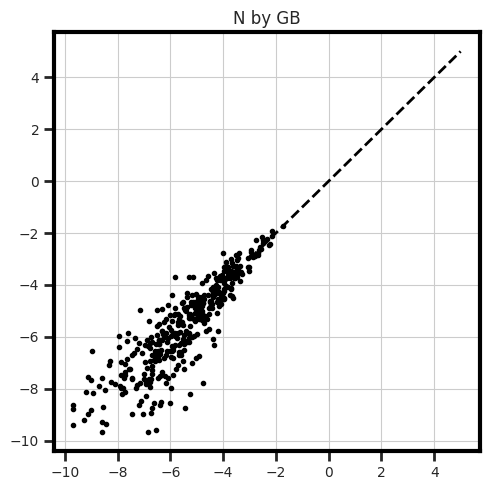

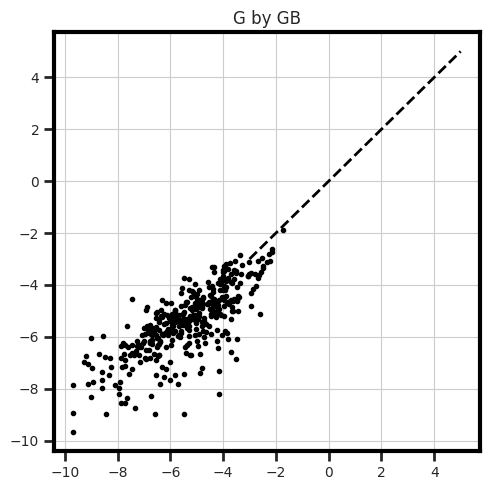

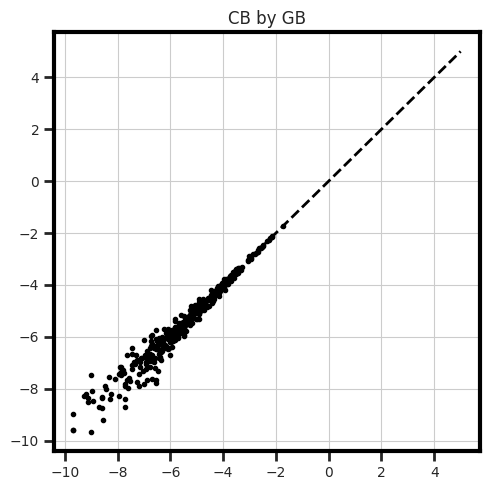

In [14]:
sns.set_style('whitegrid')
plt.rcParams['xtick.bottom'] = True
plt.rcParams['xtick.major.size'] = 7
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.left'] = True

plt.rcParams['ytick.major.size'] = 7
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.minor.width'] = 1

unit_by_condition = data.set_index(
    ['condition', 'unit', 'motif', 'gap']
).groupby(
    ['condition', 'unit']
).mean().unstack(0).droplevel(
    0, axis=1
)
ubc_logged = unit_by_condition.apply(
    np.log
).replace(
    [np.inf, -np.inf], np.nan
).dropna(axis=0, how='any')

for c in ['C', 'N', 'G', 'CB']:
    ax = plt.figure(figsize=(5,5)).add_subplot()
    ax.plot([llim,ulim], [llim,ulim], color='black', ls='--', lw=2)
    ax.plot( ubc_logged['GB'], ubc_logged[c], '.', color='black')
    #ax.set_xlim(llim,ulim)
    #ax.set_ylim(llim,ulim)
    #ax.set_xticks([-3,0,3], [])
    #ax.set_yticks([-3,0,3], [])
    plt.setp(ax.spines.values(), lw=3, color='black')
    ax.set_title(f"{c} by GB")
    plt.tight_layout()

In [16]:
for c in ['C', 'G', 'N', 'CB']:
    corr = ss.pearsonr(unit_by_condition[c].values, unit_by_condition['GB'].values)
    r = corr.statistic
    se = np.sqrt( (1 - r**2) / (len(unit_by_condition[c].values)-2) )
    print(f"{c} - GB, corr. coef.: {r:.3f}, stderr: {se:.3f}")

C - GB, corr. coef.: 0.896, stderr: 0.022
G - GB, corr. coef.: 0.818, stderr: 0.029
N - GB, corr. coef.: 0.948, stderr: 0.016
CB - GB, corr. coef.: 0.998, stderr: 0.003


## Tone-Noise Similarity Index

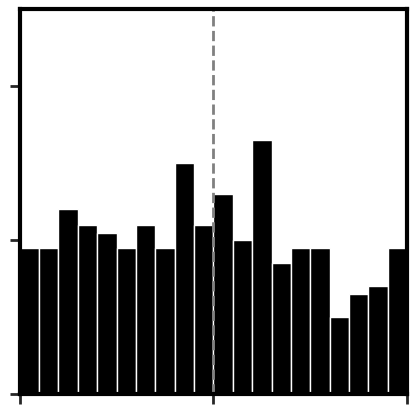

In [17]:
A = np.abs(unit_by_condition['N'] - unit_by_condition['GB'])
B = np.abs(unit_by_condition['C'] - unit_by_condition['GB'])
unit_by_condition['TNSI'] = (A-B)/(A+B)

A = np.abs(unit_by_condition['G'] - unit_by_condition['GB'])
B = np.abs(unit_by_condition['C'] - unit_by_condition['GB'])
unit_by_condition['TGSI'] = (A-B)/(A+B)

sns.set_style('whitegrid')
plt.rcParams['xtick.major.size'] = 7
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['xtick.bottom'] = True

plt.rcParams['ytick.major.size'] = 7
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['ytick.left'] = True

ax = plt.figure(figsize=(5,5)).add_subplot()
unit_by_condition['TNSI'].hist(ax=ax, grid=False, bins=20, color='black')
ax.set_ylim(0,50)
ax.set_xlim(-1, 1)
ax.set_yticks([0,20,40], [])
# ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.set_xticks([-1,0,1], [])
# ax.xaxis.set_minor_locator(AutoMinorLocator())

plt.setp(ax.spines.values(), lw=3, color='black')
ax.axvline(0, ls='--', lw=2, color='grey')

## Raster Plots

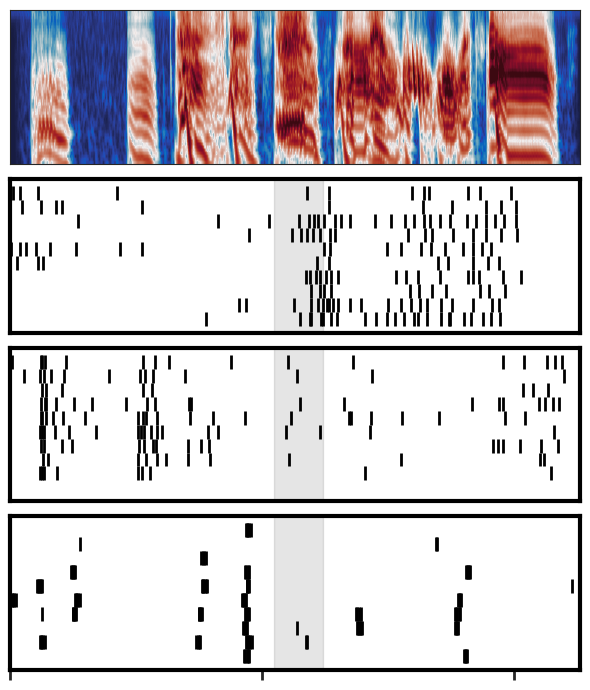

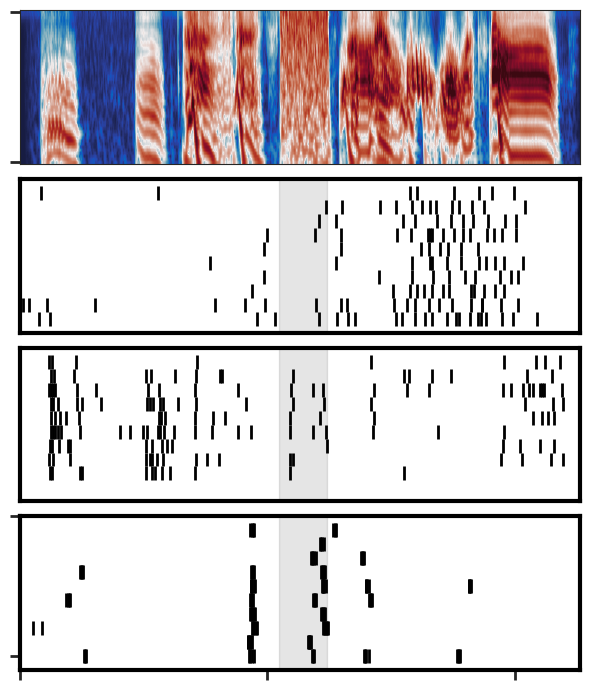

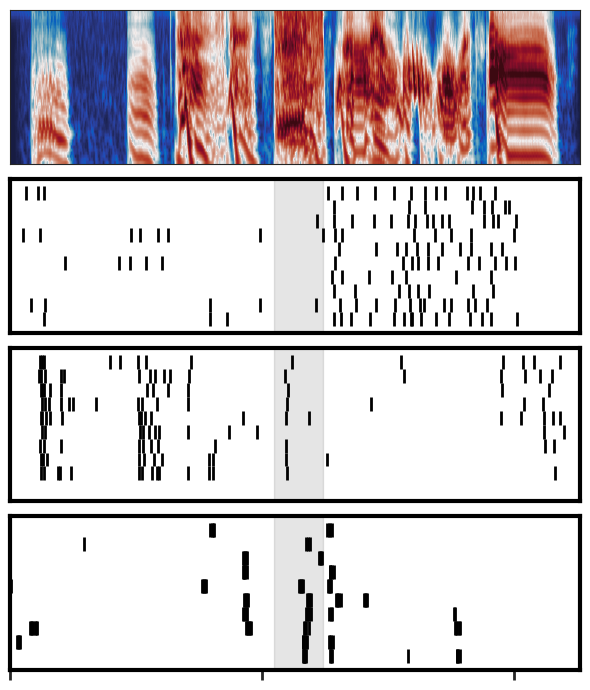

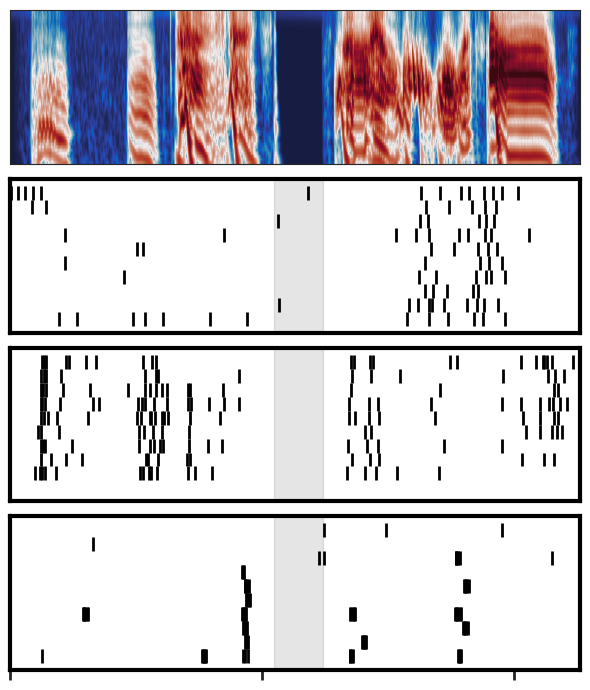

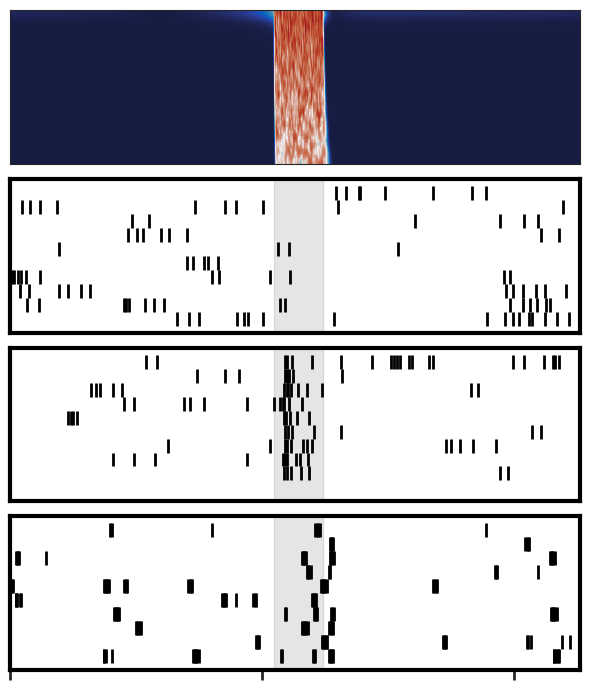

In [24]:
sns.set_style('white')
plt.rcParams['xtick.major.size'] = 7
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['xtick.bottom'] = True

plt.rcParams['ytick.major.size'] = 7
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['ytick.left'] = True

m = motifs[6]
g = 2
ga, gb = gap_times.loc[m, g]
us = ['G158_p3r2_ch6_c41','P74_p1r1_ch4_c21', 'P47_p1r3_ch21_c23']

for ic, c in enumerate(['C', 'GB', 'CB', 'G', 'N']):
    fig, ax = plt.subplots(4, 1, figsize=(6,7))

    stim = aname(m,c,g)
    spec = spectrograms.loc[stim]
    tmax = spec.index.max()
    ax[0].imshow(
        spec.T.iloc[::-1], cmap=cmap, aspect='auto', vmin=0, vmax=3
    )
    if c!='GB':
        ax[0].set_xticks([])
        ax[0].set_yticks([])
    else:
        ax[0].set_yticks([0,49], [])
        ax[0].set_xticks([])
    for iu, u in enumerate(us):
        pprox_file = Path(f"../datasets/{exp}-{dataset}-responses/{u}.pprox")
        pprox_data = json.loads(pprox_file.read_text())
        unit_data = pd.json_normalize(pprox_data["pprox"]).rename(
            columns = {'stimulus': 'motif'}
        )
        unit_data['stimulus'] = unit_data["motif"] + "_" + unit_data["condition"]
        unit_data.set_index('stimulus', inplace=True)
        events = unit_data.loc[stim].event.values
        
        plt.setp(ax[iu+1].spines.values(), lw=3, color='black')
        ax[iu+1].fill_between([ga, gb], y1=-1, y2=10, color='black', alpha=0.1)
        ax[iu+1].eventplot(events, color='black', lw=2)

        ax[iu+1].set_xlim(0, tmax)
        ax[iu+1].set_ylim(-1, 10)
        if (c=='GB') & (iu==2):
            ax[iu+1].set_xticks([0, 400, 800], [])
            ax[iu+1].set_yticks([0, 10], [])
        elif (iu==2):
            ax[iu+1].set_xticks([0, 400, 800], [])
            ax[iu+1].set_yticks([])
        else:
            ax[iu+1].set_xticks([])
            ax[iu+1].set_yticks([])
            
        plt.tight_layout()

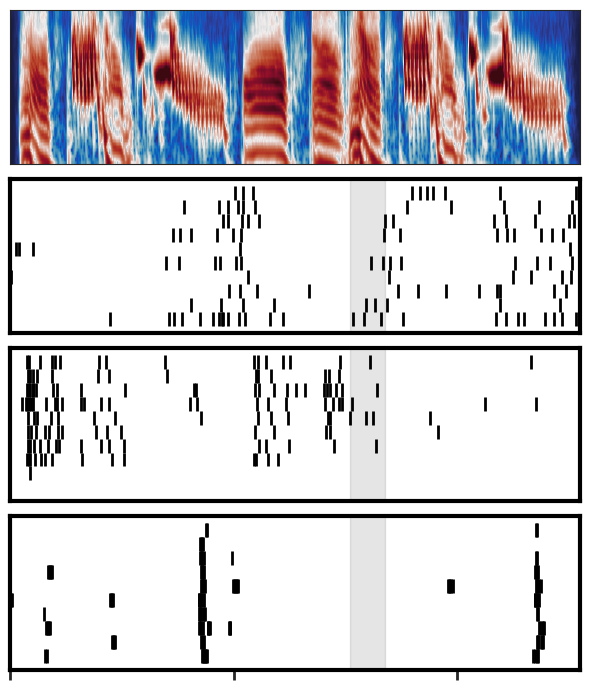

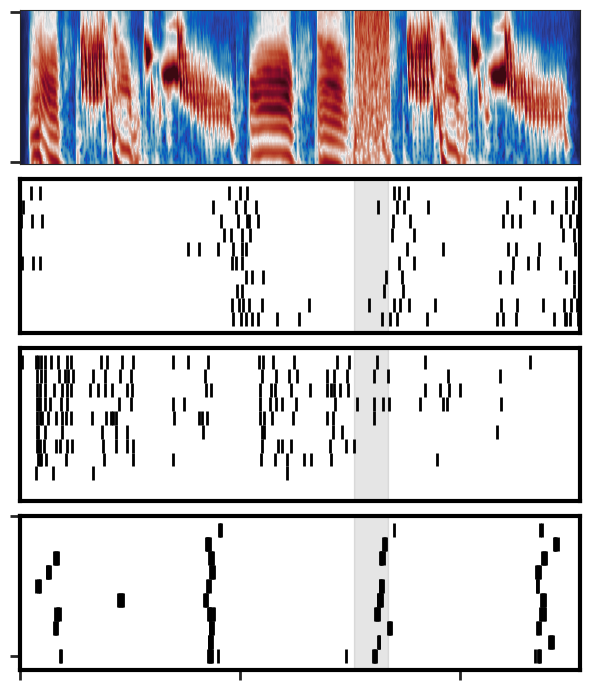

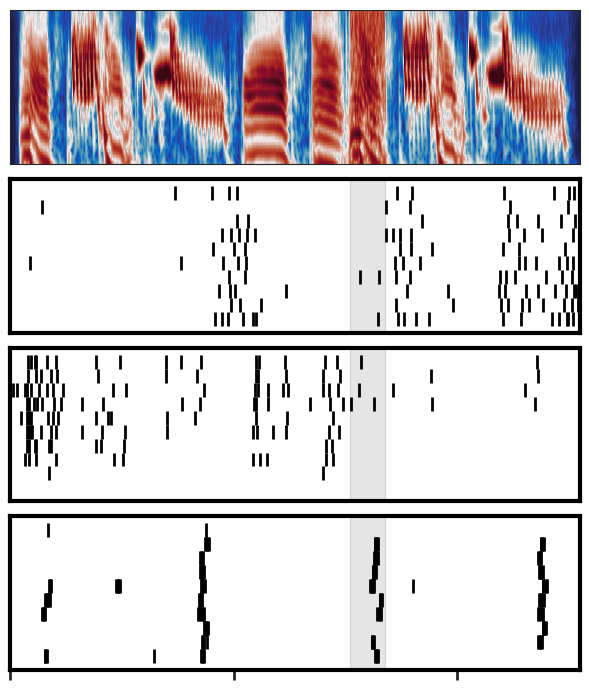

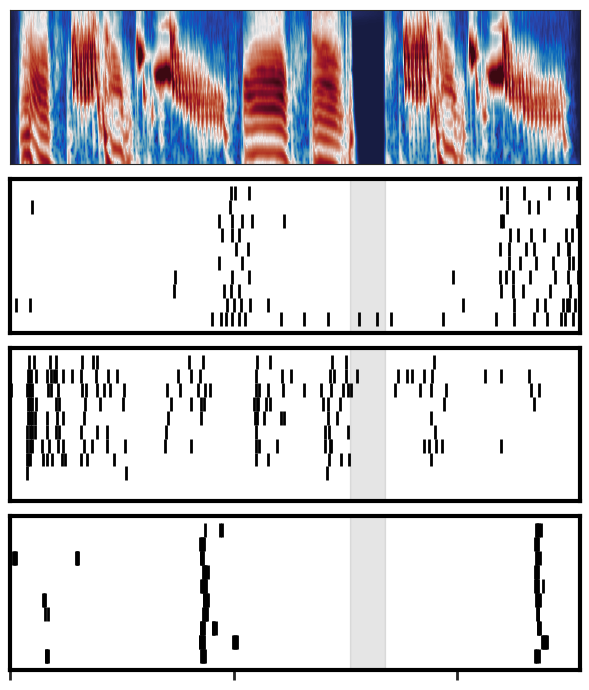

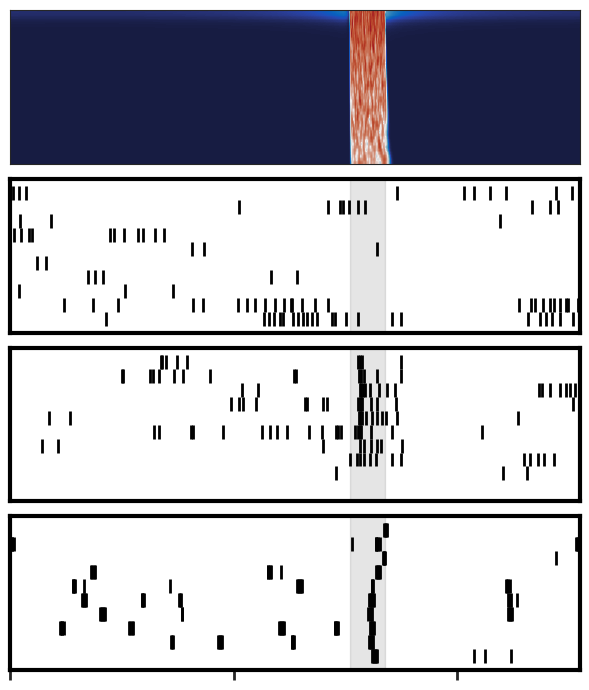

In [27]:
sns.set_style('white')
plt.rcParams['xtick.major.size'] = 7
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['xtick.bottom'] = True

plt.rcParams['ytick.major.size'] = 7
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['ytick.left'] = True

m = motifs[3]
g = 1
ga, gb = gap_times.loc[m, g]
us = ['G158_p3r2_ch6_c41','P74_p1r1_ch4_c21', 'P47_p1r3_ch21_c23']

for ic, c in enumerate(['C', 'GB', 'CB', 'G', 'N']):
    fig, ax = plt.subplots(4, 1, figsize=(6,7))

    stim = aname(m,c,g)
    spec = spectrograms.loc[stim]
    tmax = spec.index.max()
    ax[0].imshow(
        spec.T.iloc[::-1], cmap=cmap, aspect='auto', vmin=0, vmax=3
    )
    if c!='GB':
        ax[0].set_xticks([])
        ax[0].set_yticks([])
    else:
        ax[0].set_yticks([0,49], [])
        ax[0].set_xticks([])
    for iu, u in enumerate(us):
        pprox_file = Path(f"../datasets/{exp}-{dataset}-responses/{u}.pprox")
        pprox_data = json.loads(pprox_file.read_text())
        unit_data = pd.json_normalize(pprox_data["pprox"]).rename(
            columns = {'stimulus': 'motif'}
        )
        unit_data['stimulus'] = unit_data["motif"] + "_" + unit_data["condition"]
        unit_data.set_index('stimulus', inplace=True)
        events = unit_data.loc[stim].event.values
        
        plt.setp(ax[iu+1].spines.values(), lw=3, color='black')
        ax[iu+1].fill_between([ga, gb], y1=-1, y2=10, color='black', alpha=0.1)
        ax[iu+1].eventplot(events, color='black', lw=2)

        ax[iu+1].set_xlim(0, tmax)
        ax[iu+1].set_ylim(-1, 10)
        if (c=='GB') & (iu==2):
            ax[iu+1].set_xticks([0, 400, 800], [])
            ax[iu+1].set_yticks([0, 10], [])
        elif (iu==2):
            ax[iu+1].set_xticks([0, 400, 800], [])
            ax[iu+1].set_yticks([])
        else:
            ax[iu+1].set_xticks([])
            ax[iu+1].set_yticks([])
            
        plt.tight_layout()